In [1]:
import pandas as pd
import numpy as np
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.metrics import get_time_dependent_gt

joinit_info = pd.read_csv('results/joinit_info.csv')
joinit_info

,ID,Clinical-OS,MIL-OS,Combined-OS,Clinical-DFS,MIL-DFS,Combined-DFS,OSTIME,OS,DFSTIME,DFS,group
0,primary-1.nii.gz,62.596,18.307,18.688,59.652,24.457,15.011,20,1,20,1,train
1,primary-3.nii.gz,54.674,56.775,53.924,41.490,54.264,46.073,53,0,53,0,train
2,primary-4.nii.gz,62.596,64.168,65.318,59.652,58.958,63.271,53,0,53,0,train
3,primary-10.nii.gz,62.596,62.386,64.787,59.652,51.879,57.731,48,0,48,0,train
4,primary-12.nii.gz,58.096,58.745,59.356,59.652,58.741,63.138,43,1,29,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...
453,secondary2-66.nii.gz,62.596,62.639,64.866,59.652,62.513,65.167,47,0,47,0,test
454,secondary2-67.nii.gz,62.596,60.913,64.294,59.652,58.236,62.822,56,0,56,0,test
455,secondary2-69.nii.gz,59.332,61.906,62.125,50.999,63.391,62.429,40,0,40,0,test
456,secondary2-71.nii.gz,54.674,62.673,58.911,41.490,57.955,51.452,39,0,39,0,test


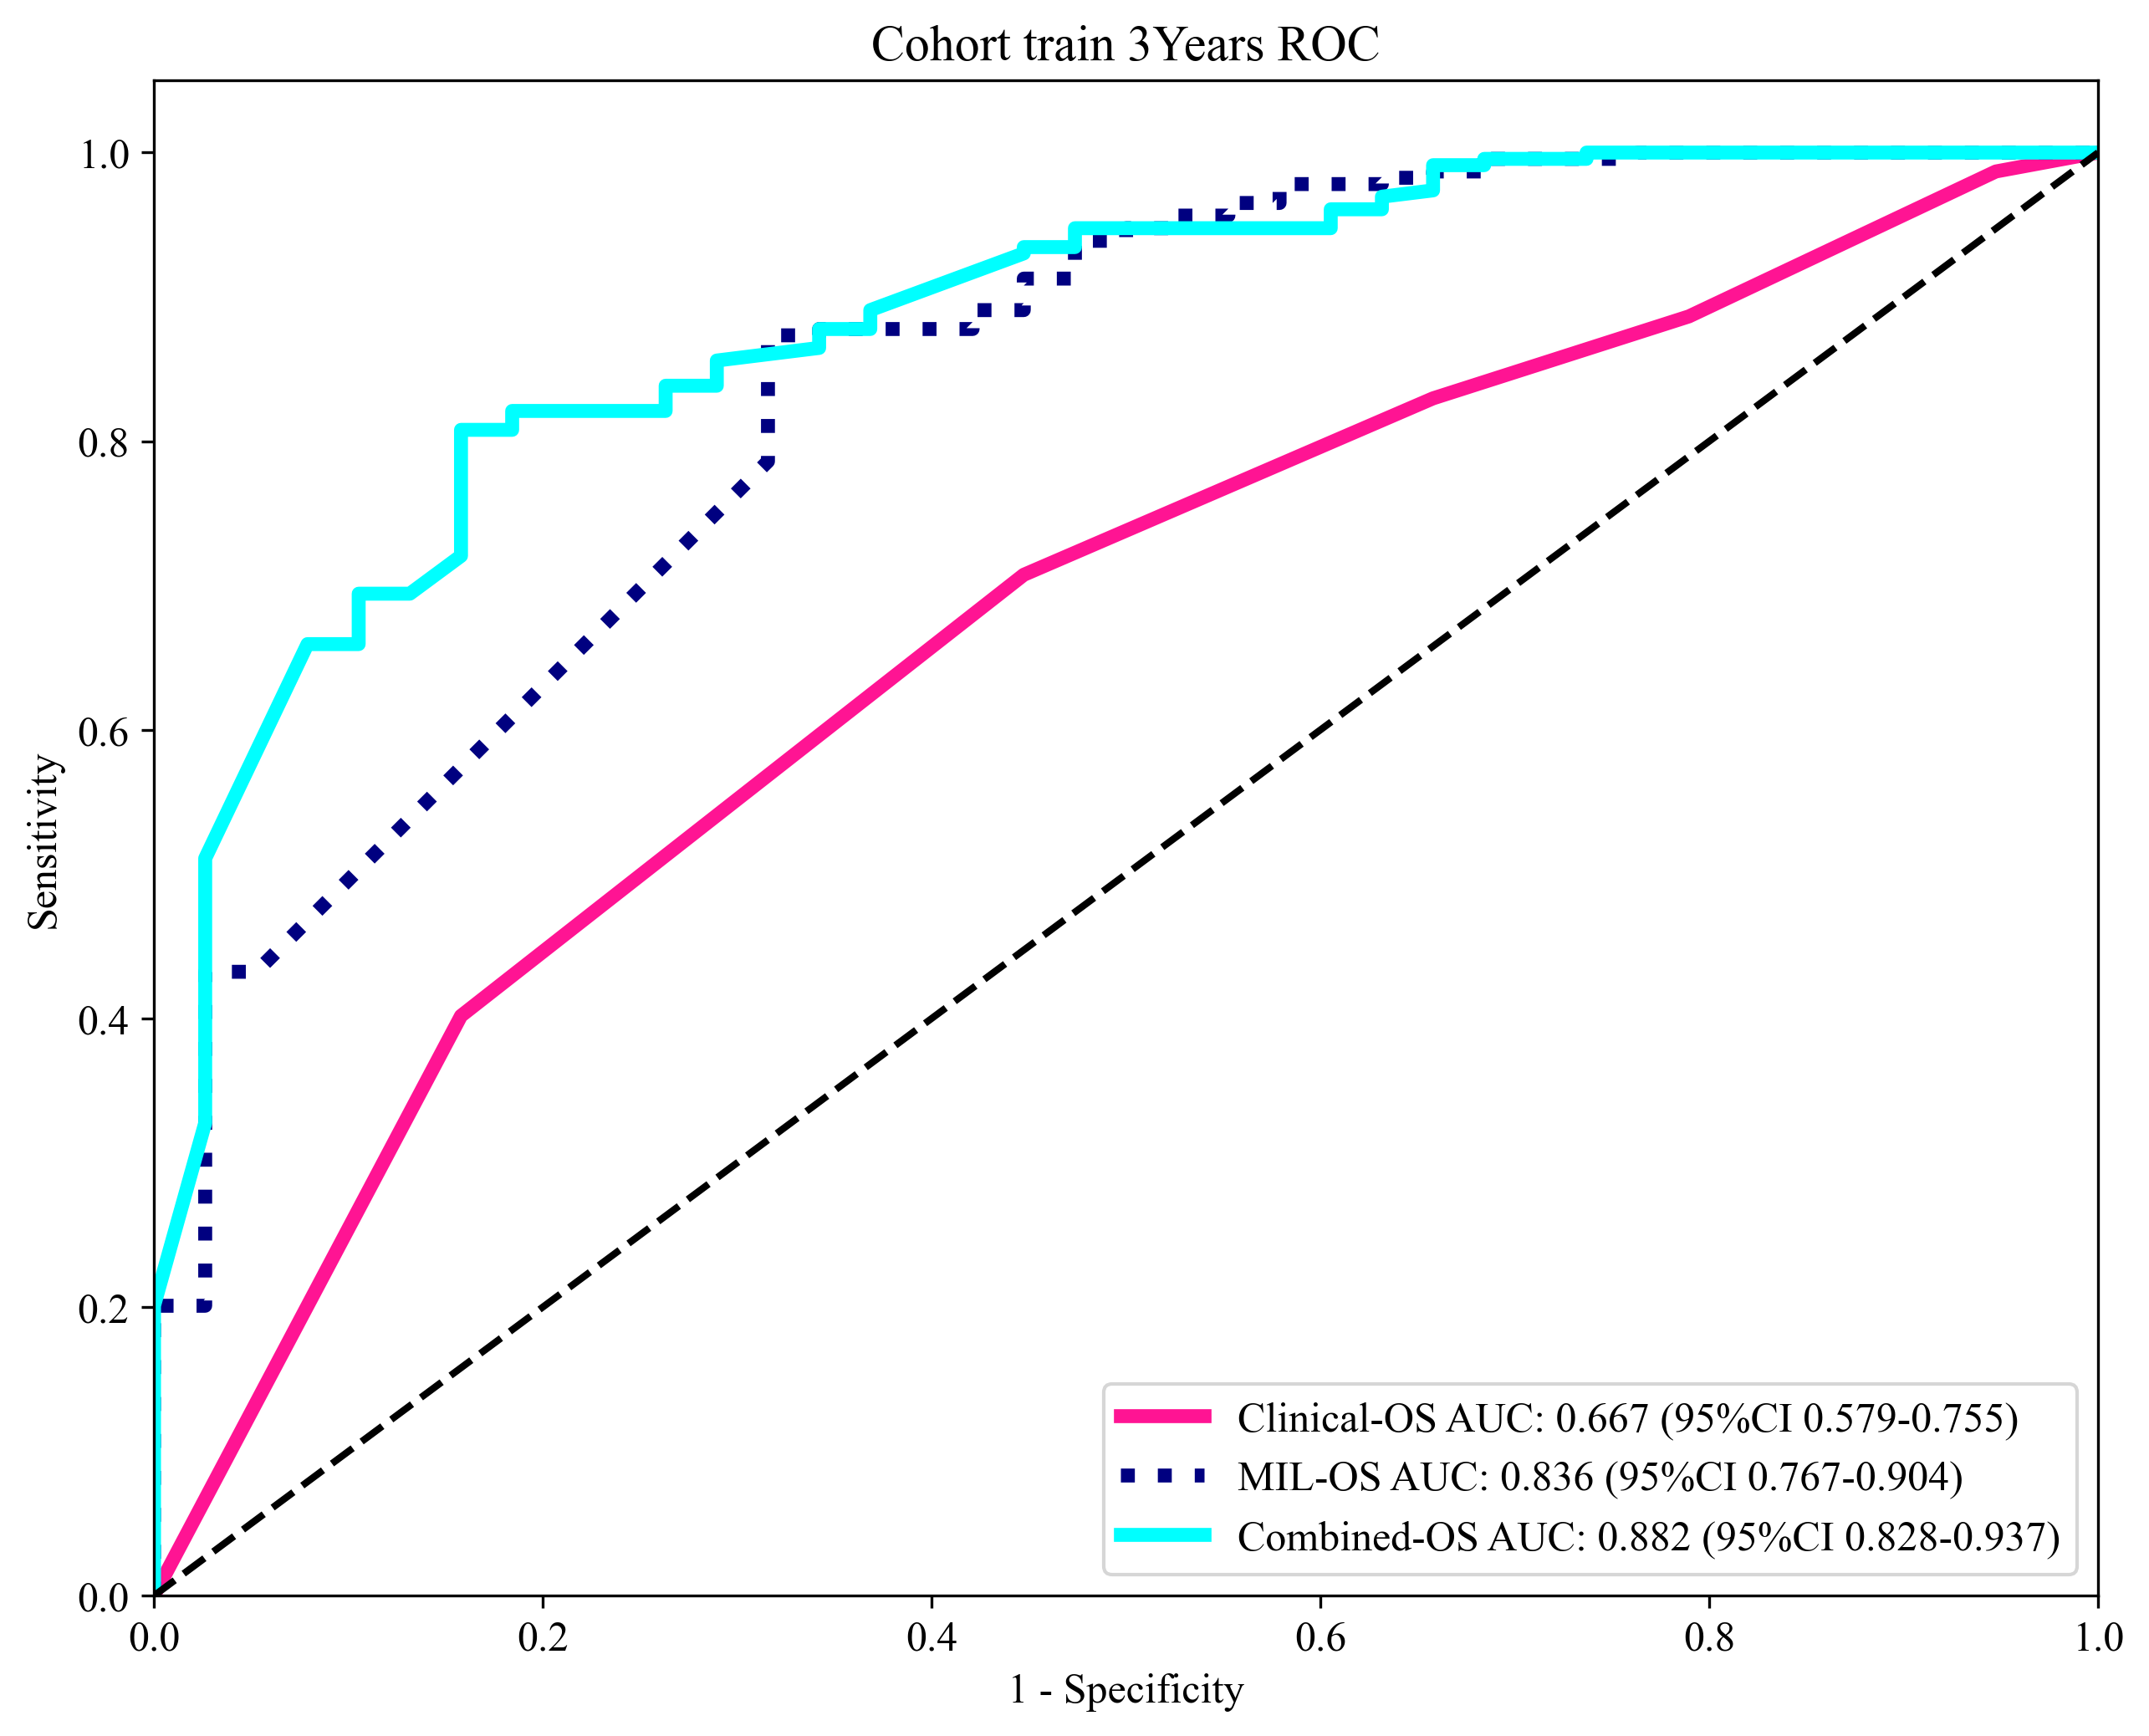

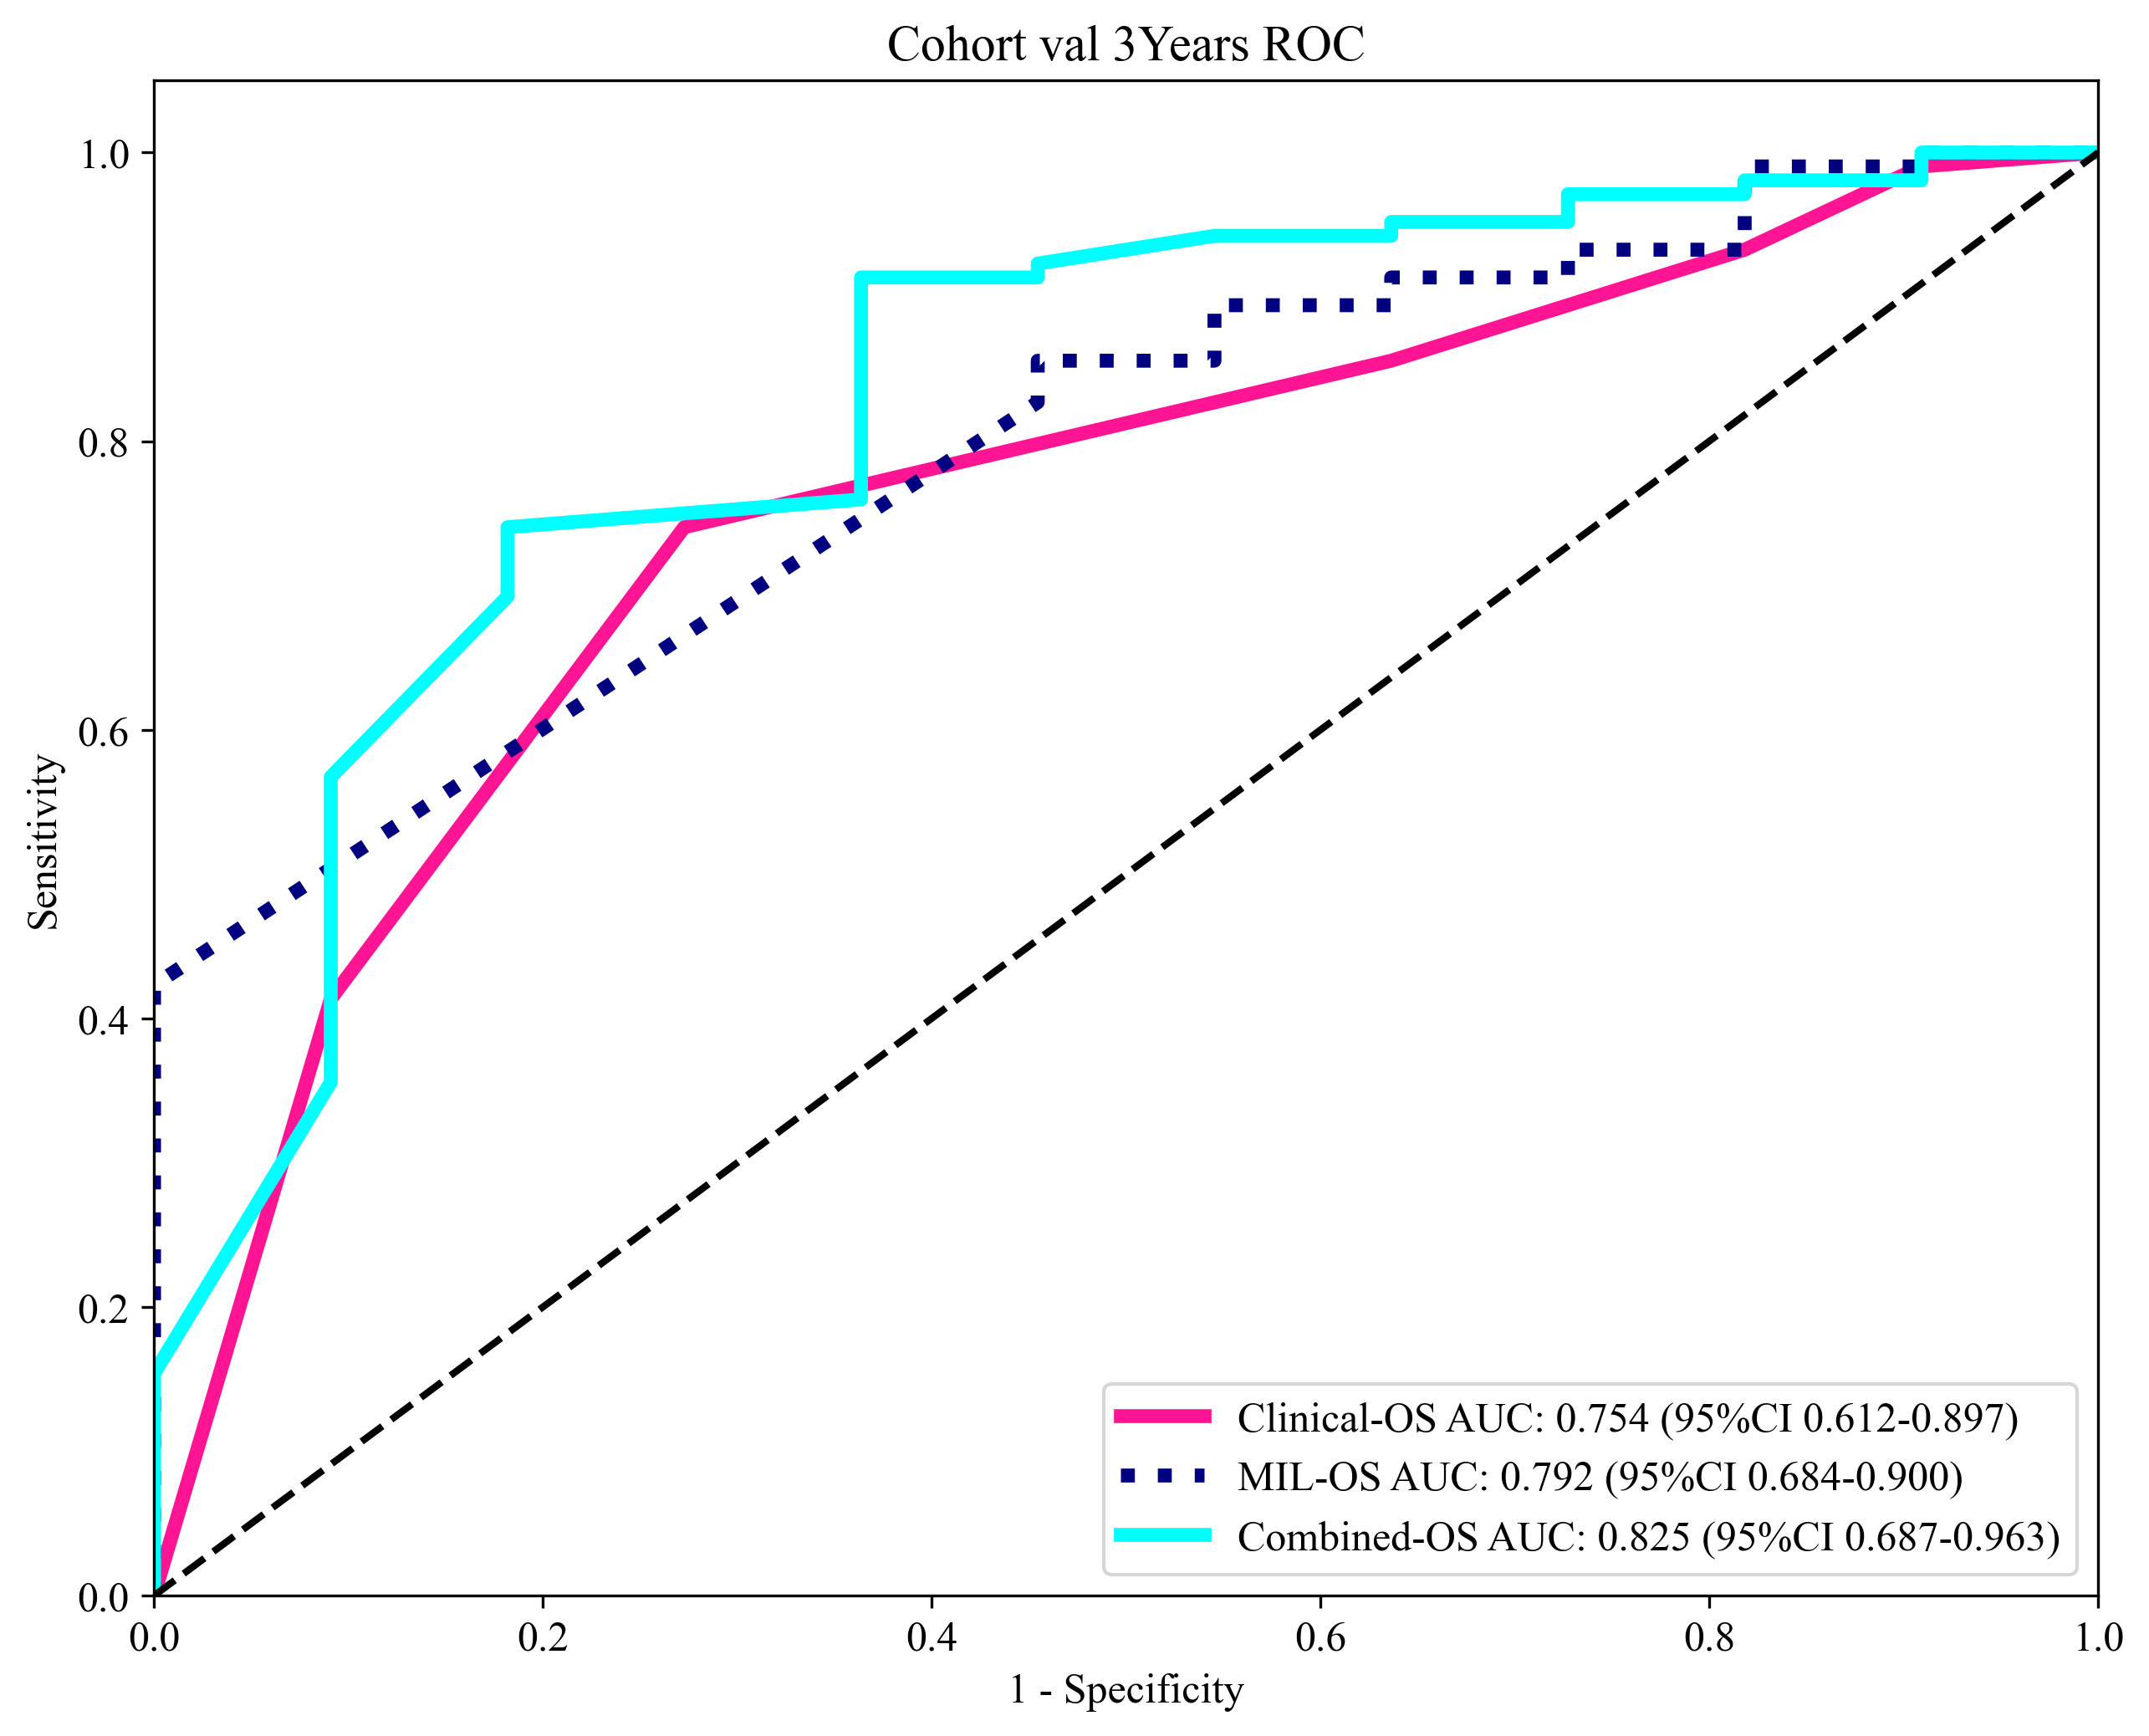

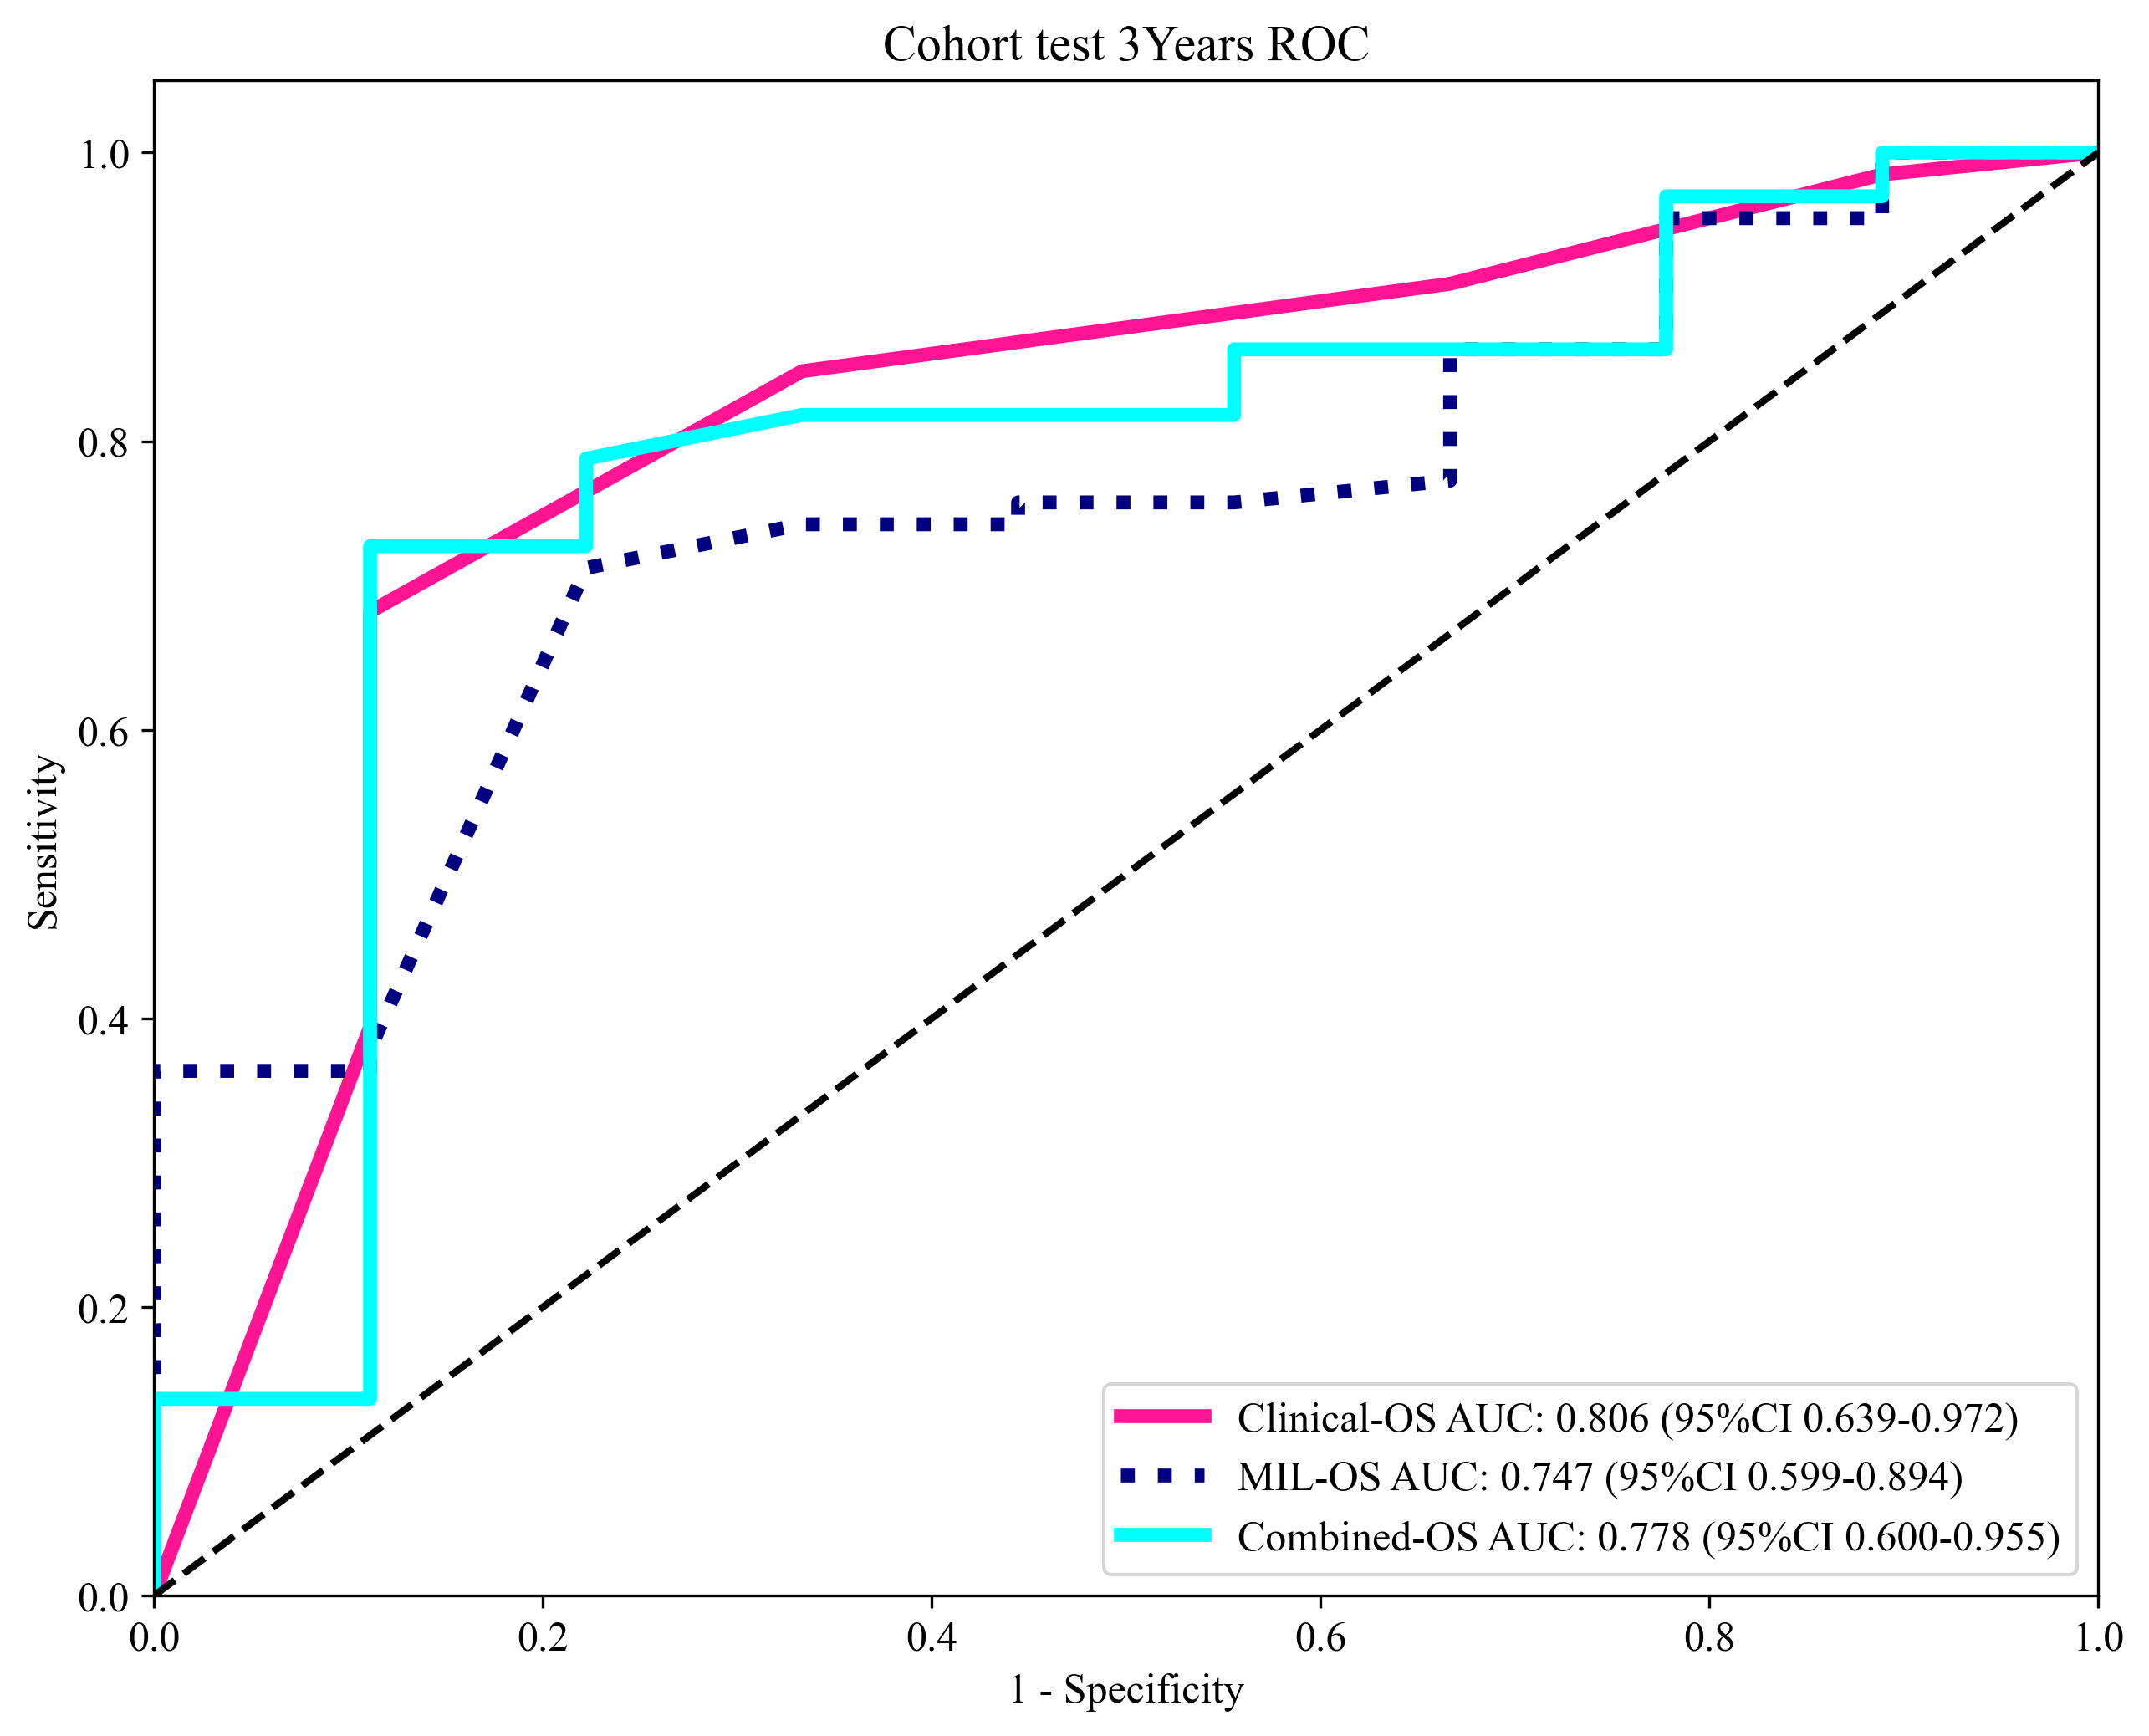

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Survival,Cohort
0,Clinical-OS,0.464,0.667,0.5794 - 0.7549,0.402,0.842,0.939,0.189,3Years,Train
1,MIL-OS,0.843,0.836,0.7669 - 0.9045,0.869,0.684,0.943,0.464,3Years,Train
2,Combined-OS,0.809,0.882,0.8275 - 0.9368,0.803,0.842,0.968,0.416,3Years,Train
3,Clinical-OS,0.461,0.754,0.6117 - 0.8970,0.413,0.909,0.977,0.141,3Years,Val
4,MIL-OS,0.470,0.792,0.6838 - 0.9001,0.413,1.000,1.000,0.153,3Years,Val
5,Combined-OS,0.739,0.825,0.6874 - 0.9629,0.731,0.818,0.974,0.243,3Years,Val
6,Clinical-OS,0.453,0.806,0.6390 - 0.9721,0.394,0.889,0.963,0.167,3Years,Test
7,MIL-OS,0.440,0.747,0.5994 - 0.8938,0.379,0.889,0.962,0.163,3Years,Test
8,Combined-OS,0.733,0.778,0.6002 - 0.9554,0.712,0.889,0.979,0.296,3Years,Test


In [2]:
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import merge_results, draw_roc
from onekey_algo.custom.components.metrics import analysis_pred_binary
from onekey_algo.custom.components.comp1 import draw_calibration
from onekey_algo.custom.components.comp1 import plot_DCA
metric = []
youden = {}
mall = []
sname = 'OS'
event_col = sname
duration_col = f"{event_col}TIME"
model_names = [mn for mn in get_param_in_cwd('compare_models') if event_col in mn]

for time, tname in [(2.99*12, '3Years')]:
    gts = []
    preds = []
    for subset in get_param_in_cwd('subsets'):
        data = joinit_info[joinit_info['group'] == subset]
        time_label_data = get_time_dependent_gt(data, time=time, event_col=event_col, duration_col=duration_col)
        ALL_results = merge_results(data, time_label_data)
        ALL_results = ALL_results.drop_duplicates('ID')
#         display(ALL_results)
        gt = [1-np.array(ALL_results['label']) for _ in model_names]
        pred_train = [np.array(ALL_results[d]) for d in model_names]
        gts.extend(gt)
        preds.extend(pred_train)
        draw_roc(gt, pred_train, labels=model_names, title=f'Cohort {subset} {tname} ROC')
        plt.savefig(f'img/{tname}_{sname}_{subset}_auc.svg')
        plt.show()
        for mname, y, score in zip(model_names, gt, pred_train):
            # 计算验证集指标
            acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score)
            ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
            metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, tname, f"{subset[0].upper() + subset[1:]}"))
            youden[mname] = thres
            
            
#             plot_DCA([ALL_results[mname]], 
#                      ALL_results['label'], title=f'Cohort {subset} {mname[:-len(sname)]} {tname} DCA', labels=mname, y_min=-0.15, remap=True)
#             plt.savefig(f'img/{tname}_{sname}_{mname}_{subset}_dca.svg')
#             plt.show()
#     for idx, mn in enumerate(model_names):
#         draw_roc(gts[idx::len(model_names)], preds[idx::len(model_names)], 
#                  labels=get_param_in_cwd('subsets'), title=f"{mn[:-len(sname)]} {tname} Time Dependent ROC")
#         plt.savefig(f'img/{tname}_{sname}_{mn}_auc.svg')
#         plt.show()
        
#         draw_calibration(pred_scores=preds[idx::len(model_names)], n_bins=5, remap=True,
#                          y_test=gts[idx::len(model_names)], model_names=get_param_in_cwd('subsets'))
#         plt.title(f"{mn[:-3]} {tname} Calibration")
#         plt.savefig(f'img/{tname}_{sname}_{mn}_cali.svg')
#         plt.show()
pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 
                                          'PPV', 'NPV', 'Survival', 'Cohort'])

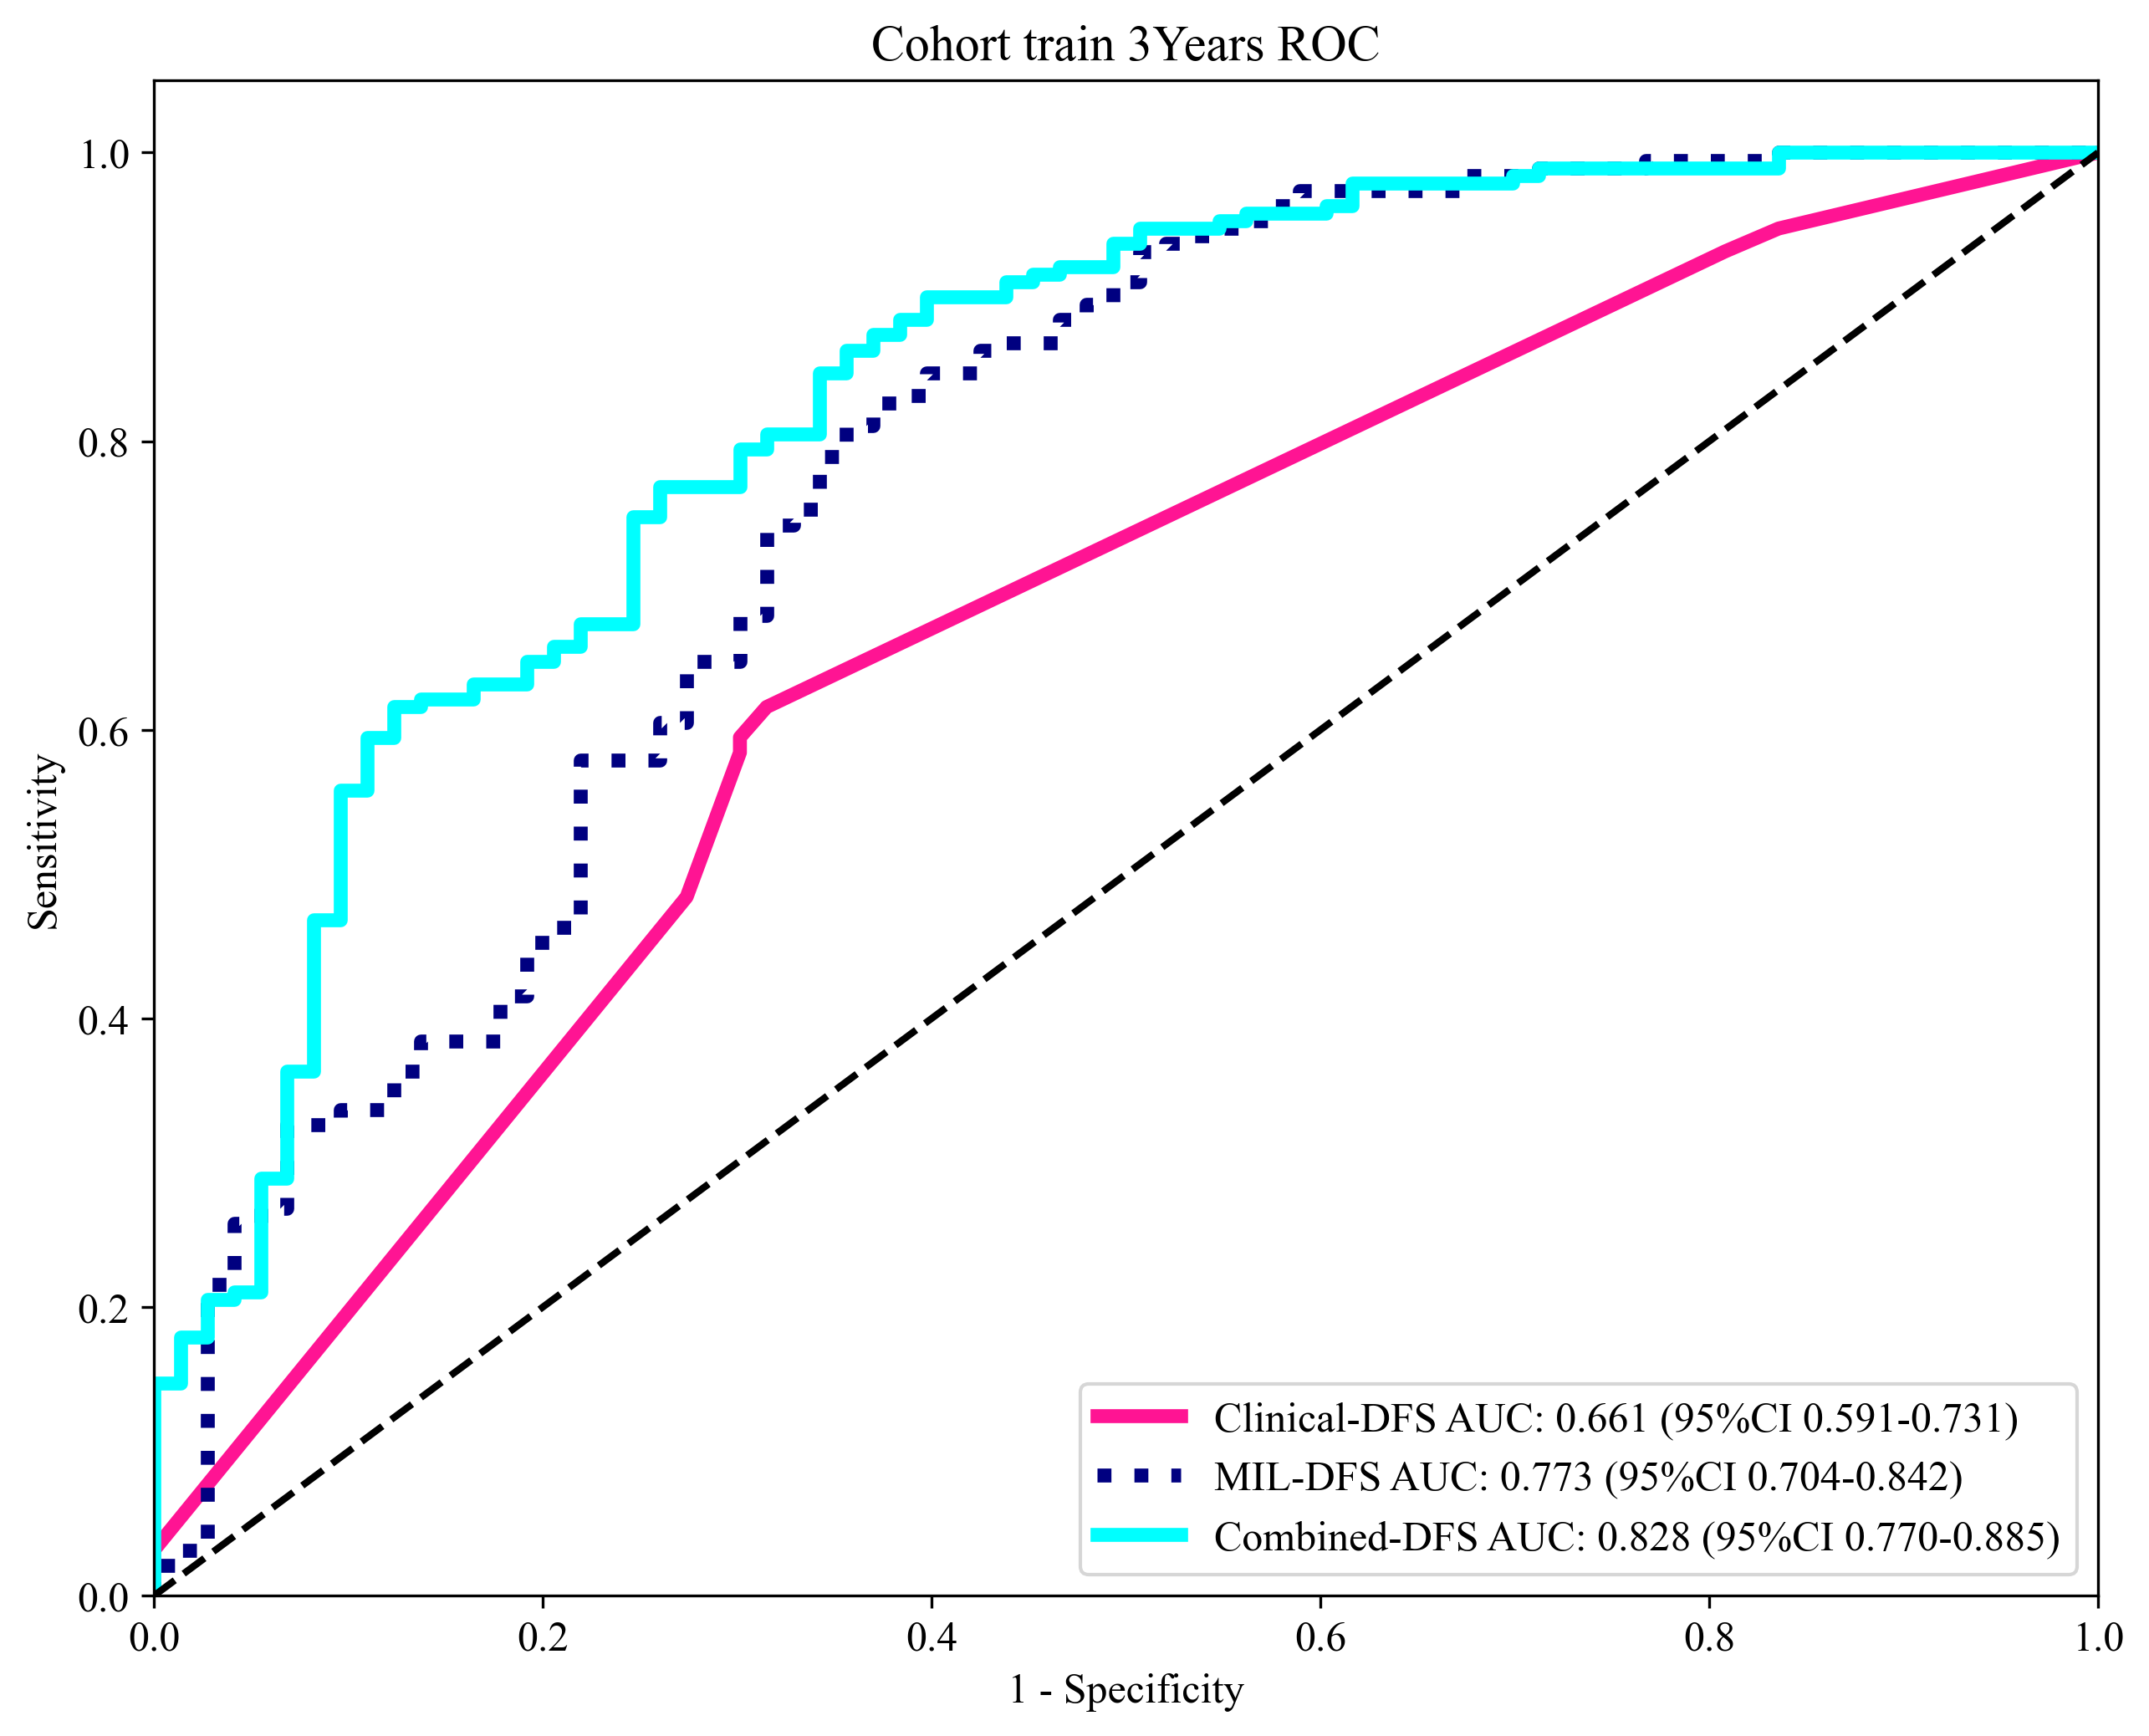

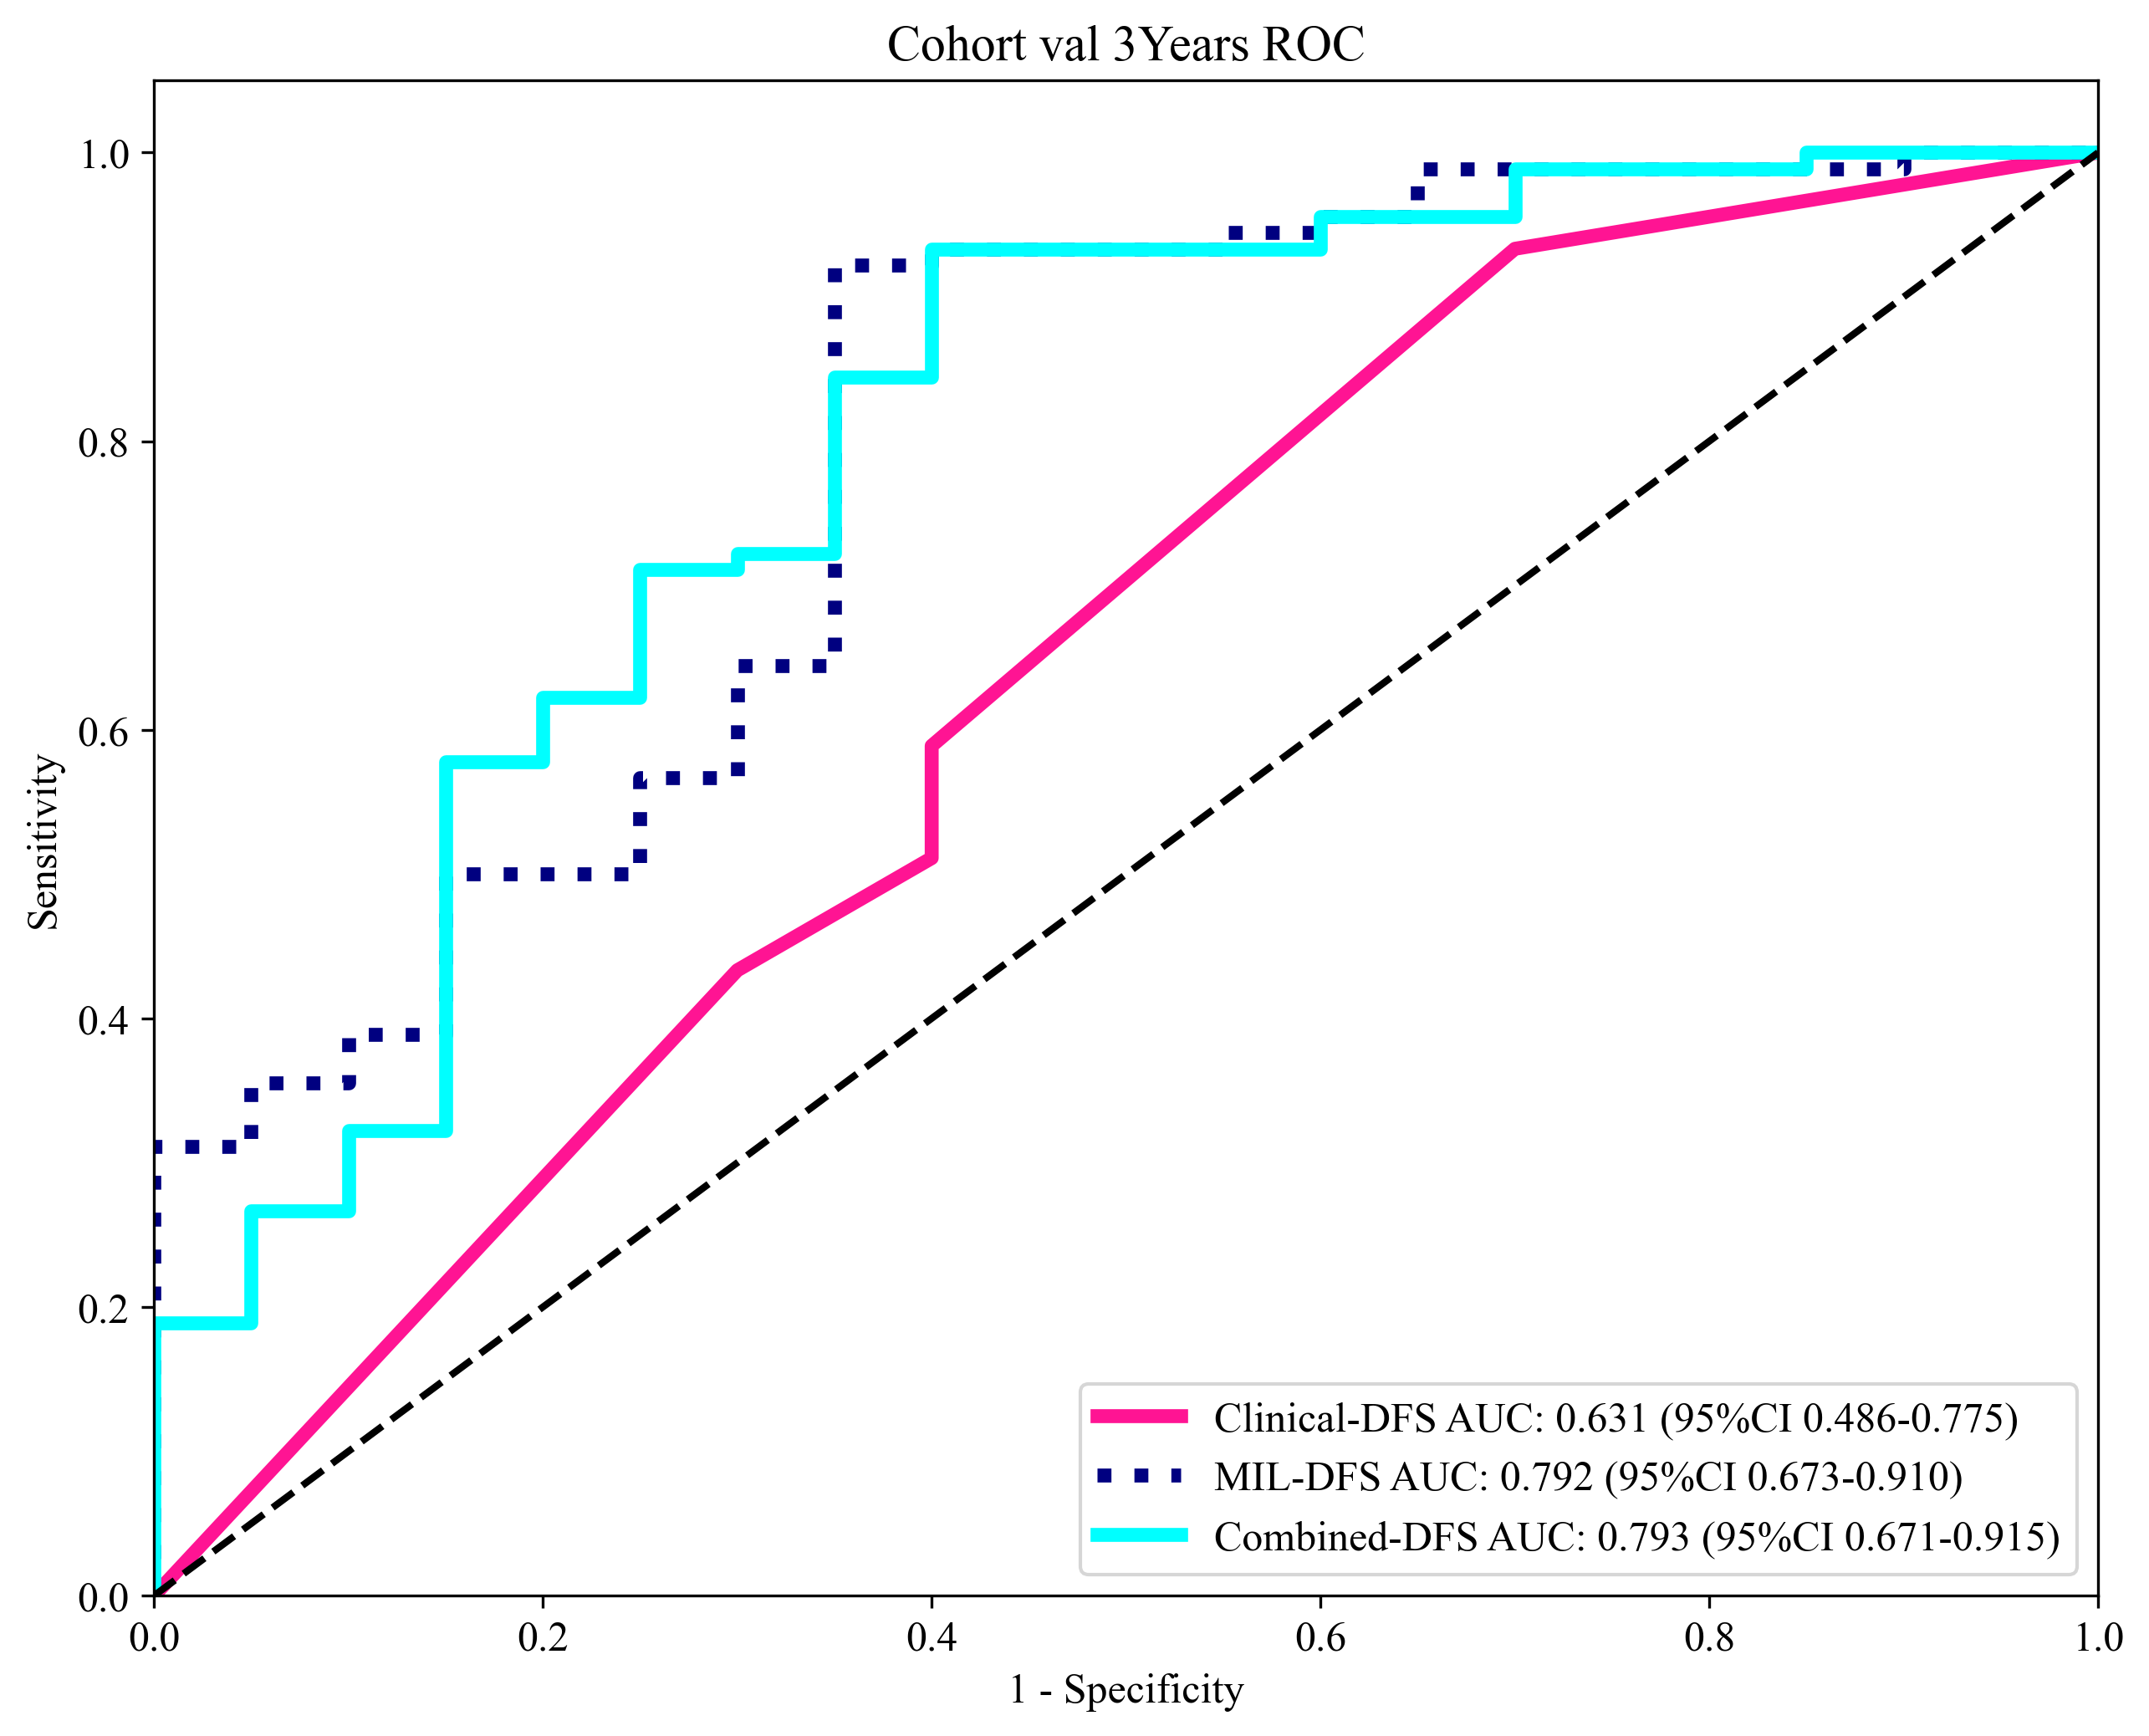

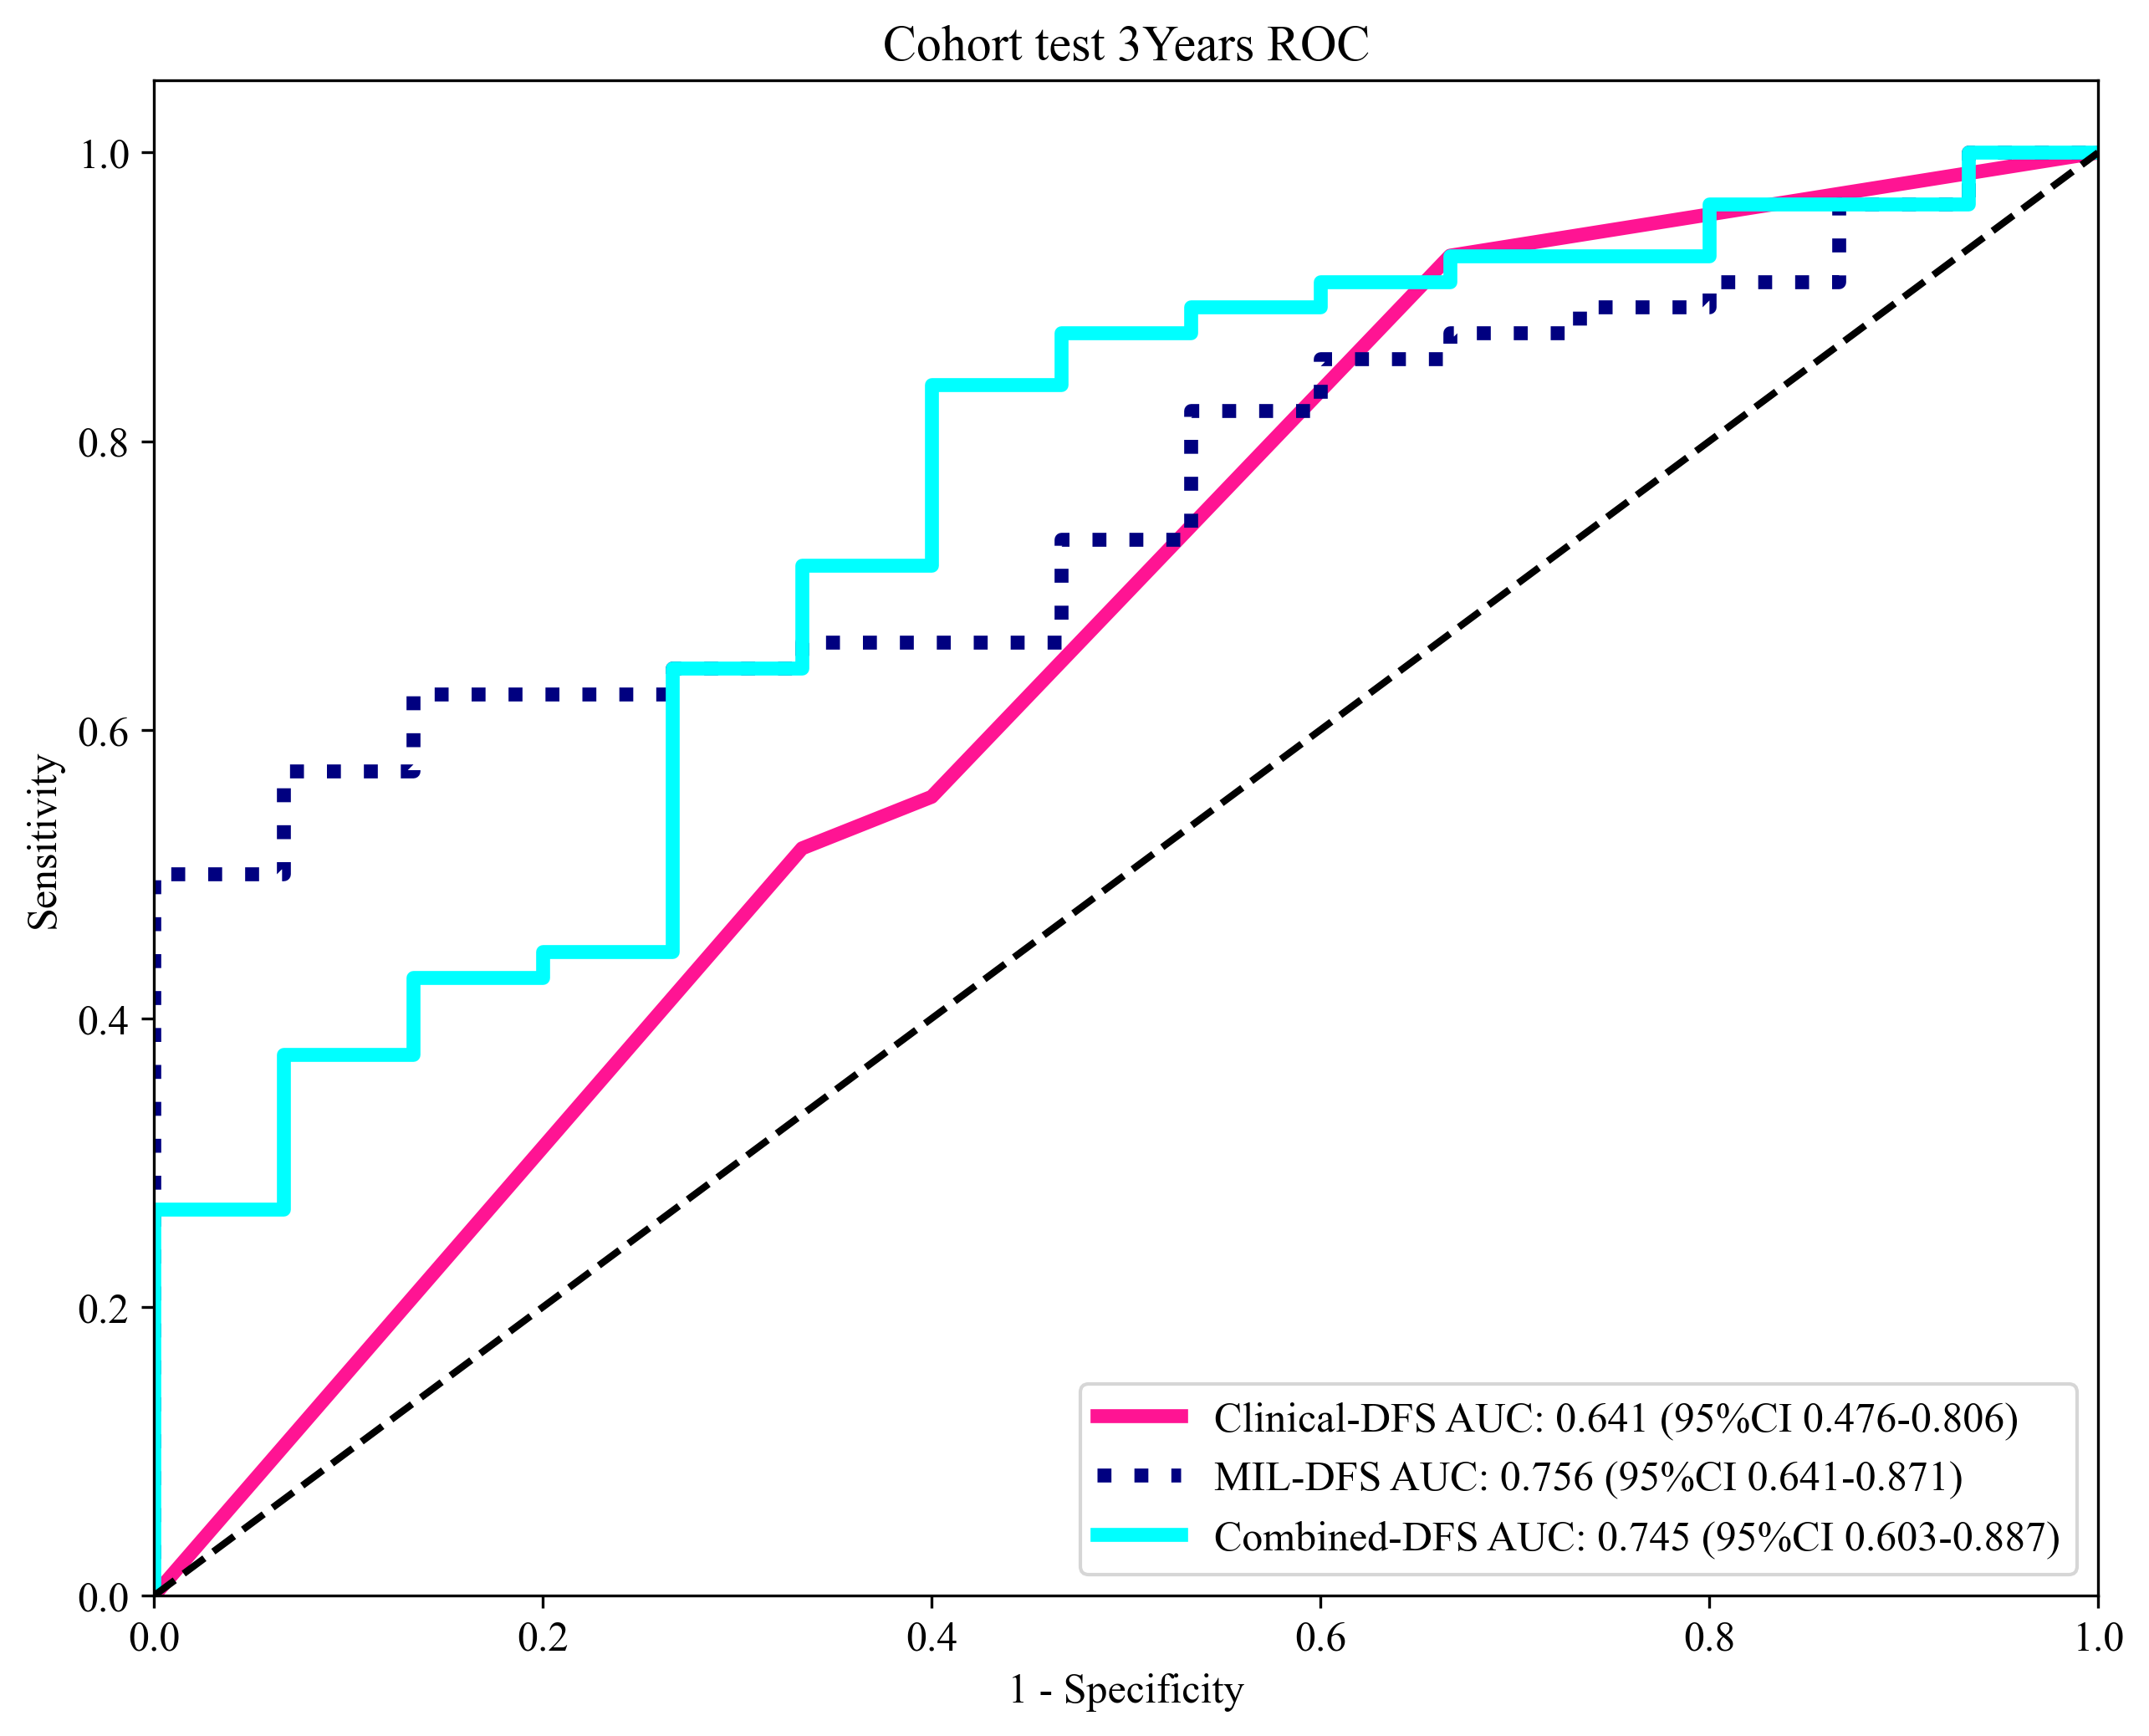

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Survival,Cohort
0,Clinical-DFS,0.624,0.661,0.5908 - 0.7310,0.595,0.699,0.837,0.398,3Years,Train
1,MIL-DFS,0.768,0.773,0.7042 - 0.8416,0.821,0.630,0.852,0.575,3Years,Train
2,Combined-DFS,0.757,0.828,0.7698 - 0.8855,0.763,0.740,0.884,0.545,3Years,Train
3,Clinical-DFS,0.591,0.631,0.4862 - 0.7749,0.589,0.600,0.869,0.245,3Years,Val
4,MIL-DFS,0.864,0.792,0.6730 - 0.9103,0.911,0.650,0.921,0.619,3Years,Val
5,Combined-DFS,0.864,0.793,0.6713 - 0.9153,0.922,0.600,0.912,0.632,3Years,Val
6,Clinical-DFS,0.563,0.641,0.4764 - 0.8057,0.554,0.600,0.838,0.265,3Years,Test
7,MIL-DFS,0.634,0.756,0.6413 - 0.8706,0.554,0.933,0.969,0.359,3Years,Test
8,Combined-DFS,0.775,0.745,0.6034 - 0.8870,0.821,0.600,0.885,0.474,3Years,Test


In [4]:
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import merge_results, draw_roc
from onekey_algo.custom.components.metrics import analysis_pred_binary
from onekey_algo.custom.components.comp1 import draw_calibration
from onekey_algo.custom.components.comp1 import plot_DCA
metric = []
youden = {}
mall = []
sname = 'DFS'
event_col = sname
duration_col = f"{event_col}TIME"
model_names = [mn for mn in get_param_in_cwd('compare_models') if event_col in mn]

for time, tname in [(3*12, '3Years') ]:
    gts = []
    preds = []
    for subset in get_param_in_cwd('subsets'):
        data = joinit_info[joinit_info['group'] == subset]
        time_label_data = get_time_dependent_gt(data, time=time, event_col=event_col, duration_col=duration_col)
        ALL_results = merge_results(data, time_label_data)
        ALL_results = ALL_results.drop_duplicates('ID')
#         display(ALL_results)
        gt = [1-np.array(ALL_results['label']) for _ in model_names]
        pred_train = [np.array(ALL_results[d]) for d in model_names]
        gts.extend(gt)
        preds.extend(pred_train)
        draw_roc(gt, pred_train, labels=model_names, title=f'Cohort {subset} {tname} ROC')
        plt.savefig(f'img/{tname}_{sname}_{subset}_auc.svg')
        plt.show()
        for mname, y, score in zip(model_names, gt, pred_train):
            # 计算验证集指标
            acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score)
            ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
            metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, tname, f"{subset[0].upper() + subset[1:]}"))
            youden[mname] = thres
            
            
#             plot_DCA([ALL_results[mname]], 
#                      ALL_results['label'], title=f'Cohort {subset} {mname[:-len(sname)]} {tname} DCA', labels=mname, y_min=-0.15, remap=True)
#             plt.savefig(f'img/{tname}_{sname}_{mname}_{subset}_dca.svg')
#             plt.show()
#     for idx, mn in enumerate(model_names):
#         draw_roc(gts[idx::len(model_names)], preds[idx::len(model_names)], 
#                  labels=get_param_in_cwd('subsets'), title=f"{mn[:-len(sname)]} {tname} Time Dependent ROC")
#         plt.savefig(f'img/{tname}_{sname}_{mn}_auc.svg')
#         plt.show()
        
#         draw_calibration(pred_scores=preds[idx::len(model_names)], n_bins=5, remap=True,
#                          y_test=gts[idx::len(model_names)], model_names=get_param_in_cwd('subsets'))
#         plt.title(f"{mn[:-3]} {tname} Calibration")
#         plt.savefig(f'img/{tname}_{sname}_{mn}_cali.svg')
#         plt.show()
pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 
                                          'PPV', 'NPV', 'Survival', 'Cohort'])